Air-line fare prediction system


In [1]:
# 1.Imports & Settings

import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from collections import defaultdict

# sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# trying boosters
try:
    import xgboost as xgb
    XGBOOST_INSTALLED = True
except Exception:
    XGBOOST_INSTALLED = False

try:
    import lightgbm as lgb
    LGBM_INSTALLED = True
except Exception:
    LGBM_INSTALLED = False

import joblib

# Plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# Path to uploaded file
DATA_PATH = "/content/airline_dataset.xlsx"   # uses your uploaded file

In [5]:
# 2.Load dataset & quick inspection

def load_data(path=DATA_PATH):
    print(f"\nLoading dataset from: {path}")
    assert os.path.exists(path), f"Dataset not found at {path}"
    df = pd.read_excel(path)
    print("Shape:", df.shape)
    display_head = df.head(5)
    display_head.to_string(index=False)
    print(display_head)
    print("\nColumn datatypes and non-null counts:")
    print(df.info())
    return df

df = load_data(DATA_PATH)


Loading dataset from: /content/airline_dataset.xlsx
Shape: (10683, 11)
       Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      24/03/2019  Banglore   New Delhi              BLR → DEL   
1    Air India       1/05/2019   Kolkata    Banglore  CCU → IXR → BBI → BLR   
2  Jet Airways       9/06/2019     Delhi      Cochin  DEL → LKO → BOM → COK   
3       IndiGo      12/05/2019   Kolkata    Banglore        CCU → NAG → BLR   
4       IndiGo      01/03/2019  Banglore   New Delhi        BLR → NAG → DEL   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897  
1    05:50         13:15   7h 25m     2 stops         No info   7662  
2    09:25  04:25 10 Jun      19h     2 stops         No info  13882  
3    18:05         23:30   5h 25m      1 stop         No info   6218  
4    16:50         21:35   4h 45m      1 stop         No info  13302  

Column datatypes and non-n

In [6]:
# 3.Storytelling EDA & missing values

def eda_overview(df):
    print("\nColumn list:", list(df.columns))
    print("\nMissing values by column:")
    missing = df.isnull().sum().sort_values(ascending=False)
    print(missing[missing > 0].to_string())
    # Basic numeric summaries if Price present
    if any(c.lower() == "price" for c in df.columns):
        price_col = [c for c in df.columns if c.lower() == "price"][0]
        print(f"\nPrice summary ({price_col}):")
        print(df[price_col].describe())
    # show distribution of a few categorical columns
    for c in ["Airline", "Source", "Destination"]:
        if c in df.columns:
            print(f"\nTop values for {c}:")
            print(df[c].value_counts().head(8).to_string())

eda_overview(df)


Column list: ['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route', 'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops', 'Additional_Info', 'Price']

Missing values by column:
Route          1
Total_Stops    1

Price summary (Price):
count    10683.000000
mean      9087.064121
std       4611.359167
min       1759.000000
25%       5277.000000
50%       8372.000000
75%      12373.000000
max      79512.000000
Name: Price, dtype: float64

Top values for Airline:
Airline
Jet Airways          3849
IndiGo               2053
Air India            1752
Multiple carriers    1196
SpiceJet              818
Vistara               479
Air Asia              319
GoAir                 194

Top values for Source:
Source
Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381

Top values for Destination:
Destination
Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381


In [7]:
# 4.Robust parsing & feature engineering

def parse_duration_to_mins(x):
    """Converting durations like '2h 50m', '130m', '02:10' to integer minutes."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip()

    if ":" in s and all(p.isdigit() for p in s.replace(":", "").split()):
        try:
            h, m = s.split(":")
            return int(h) * 60 + int(m)
        except:
            pass

    hours = 0
    mins = 0
    if "h" in s:
        try:
            hours_part, rest = s.split("h", 1)
            hours = int(''.join([ch for ch in hours_part if ch.isdigit()]) or 0)
            s = rest
        except:
            pass
    if "m" in s:
        try:
            mins = int(''.join([ch for ch in s if ch.isdigit()]) or 0)
        except:
            pass
    # fallback numeric
    if hours == 0 and mins == 0:
        digits = ''.join([ch for ch in s if ch.isdigit()])
        if digits:
            try:
                return int(digits)
            except:
                pass
    return int(hours * 60 + mins)

def feature_engineer(df):
    df = df.copy()
    # standardize column names
    df.columns = [c.strip() for c in df.columns]
    # Date_of_Journey -> Journey_Day, Journey_Month, Journey_Year
    if "Date_of_Journey" in df.columns:
        df["Date_of_Journey_parsed"] = pd.to_datetime(df["Date_of_Journey"], dayfirst=True, errors="coerce")
        df["Journey_Day"] = df["Date_of_Journey_parsed"].dt.day
        df["Journey_Month"] = df["Date_of_Journey_parsed"].dt.month
        df["Journey_Year"] = df["Date_of_Journey_parsed"].dt.year
    # Dep_Time / Arrival_Time -> hour & minute
    for col in ["Dep_Time", "Arrival_Time", "Dep Time", "Arrival Time"]:
        if col in df.columns:
            parsed = pd.to_datetime(df[col].astype(str), format="%H:%M", errors="coerce")
            if parsed.isna().sum() > 0:
                parsed = pd.to_datetime(df[col].astype(str), errors="coerce")
            df[col + "_hour"] = parsed.dt.hour
            df[col + "_minute"] = parsed.dt.minute
    # Duration -> Duration_mins
    if "Duration" in df.columns:
        df["Duration_mins"] = df["Duration"].apply(parse_duration_to_mins)
    # Total_Stops -> numeric stops
    if "Total_Stops" in df.columns:
        def stops_to_num(x):
            if pd.isna(x): return np.nan
            s = str(x).lower()
            if "non" in s:
                return 0
            import re
            m = re.search(r"(\d+)", s)
            return int(m.group(1)) if m else np.nan
        df["stops"] = df["Total_Stops"].apply(stops_to_num)
    # Route -> route_legs
    if "Route" in df.columns:
        df["route_legs"] = df["Route"].astype(str).apply(lambda x: len([p for p in x.replace("→", "-").split("-") if p.strip() != ""]))
    # Create a weekday flag from journey date
    if "Date_of_Journey_parsed" in df.columns:
        df["Journey_Weekday"] = df["Date_of_Journey_parsed"].dt.weekday  # Monday=0
    # If Price exists, keep it as numeric
    price_col = None
    for c in df.columns:
        if c.lower() == "price":
            price_col = c
            break
    if price_col:
        df[price_col] = pd.to_numeric(df[price_col], errors="coerce")
        # log-transform for modelling stability
        df["log_price"] = np.log1p(df[price_col])
    return df

df_fe = feature_engineer(df)
print("\nAfter feature engineering, columns include:", [c for c in df_fe.columns if c.endswith("_hour") or c in ("Duration_mins", "stops", "route_legs", "Journey_Day", "Journey_Month", "log_price")])


After feature engineering, columns include: ['Journey_Day', 'Journey_Month', 'Dep_Time_hour', 'Arrival_Time_hour', 'Duration_mins', 'stops', 'route_legs', 'log_price']


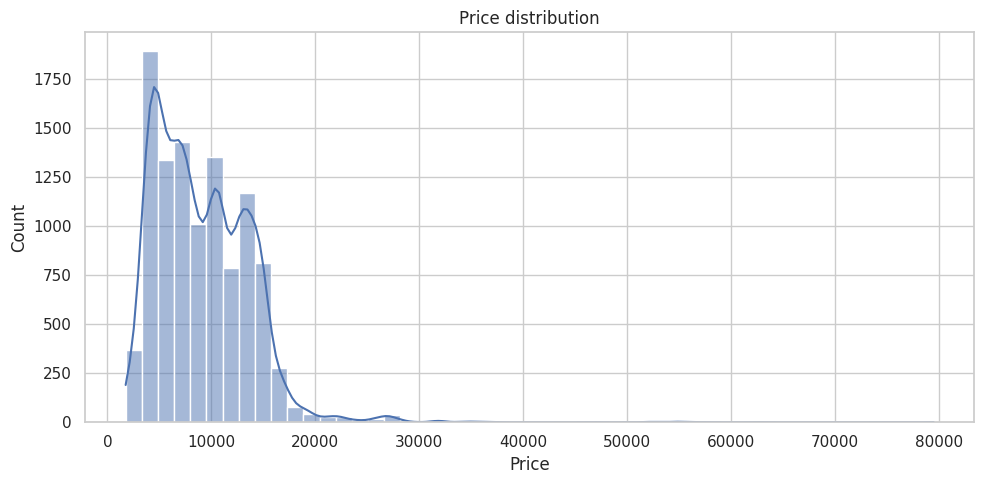

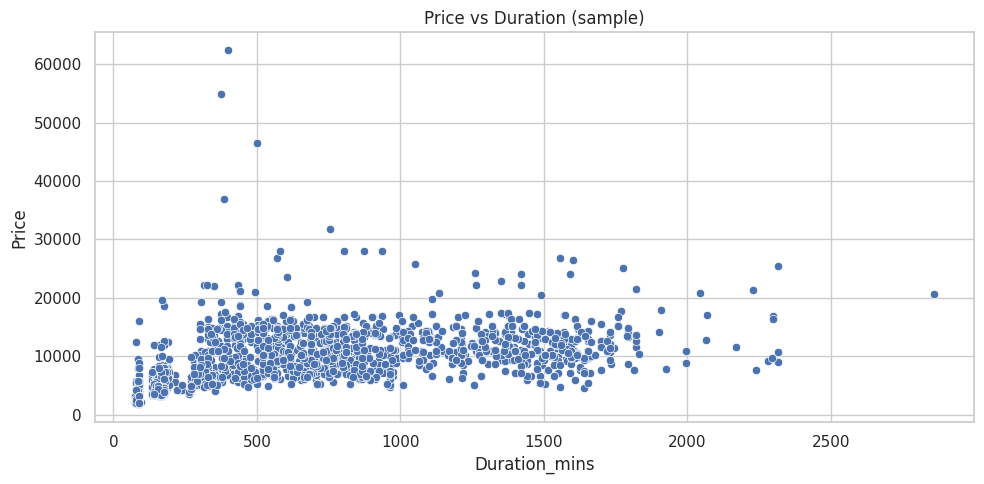

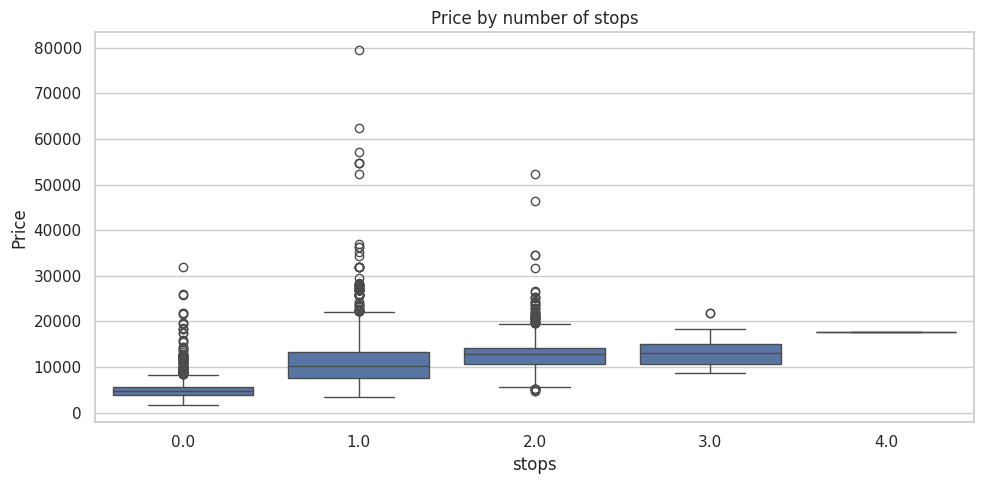

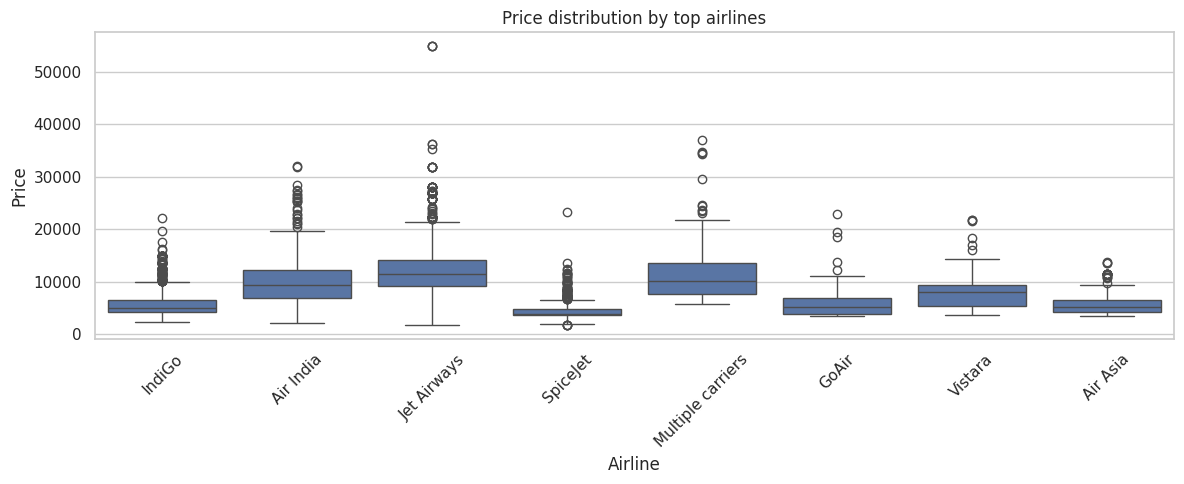

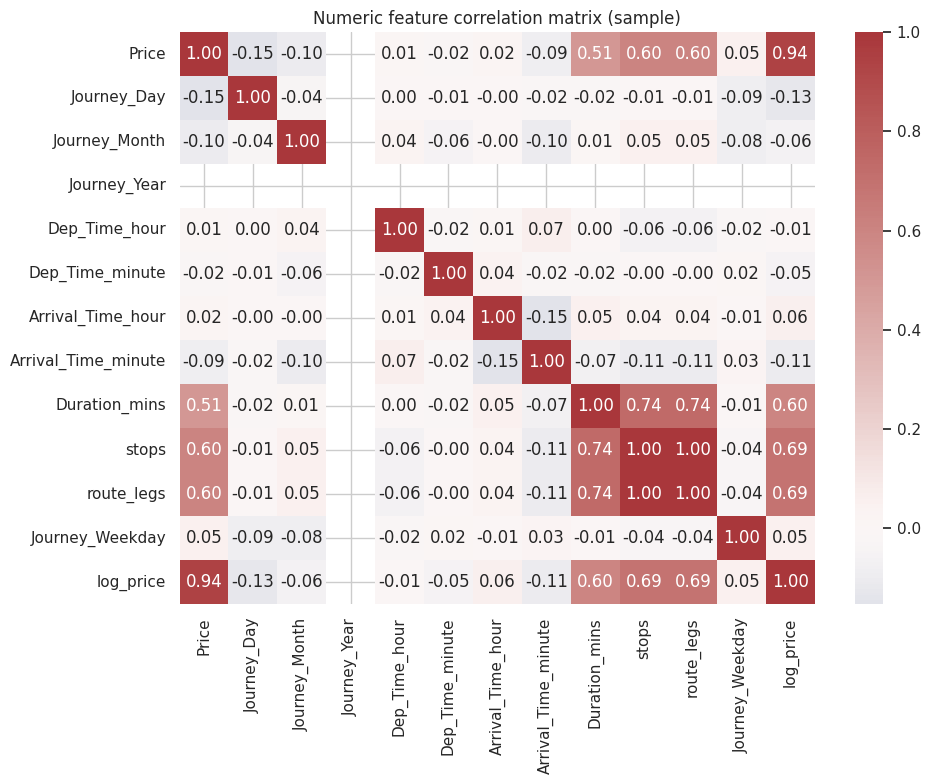

In [8]:
# 5.Visual Exploratory Data Analysis (story + plots)

def eda_plots(df):
    price_col = next((c for c in df.columns if c.lower() == "price"), None)
    if price_col is None:
        print("No price column found for EDA plots.")
        return
    # Price distribution
    plt.figure()
    sns.histplot(df[price_col].dropna(), kde=True, bins=50)
    plt.title("Price distribution")
    plt.xlabel("Price")
    plt.tight_layout()
    plt.show()
    # Price vs Duration
    if "Duration_mins" in df.columns:
        plt.figure()
        sns.scatterplot(x="Duration_mins", y=price_col, data=df.sample(2000, random_state=1))
        plt.title("Price vs Duration (sample)")
        plt.tight_layout()
        plt.show()
    # Price by number of stops
    if "stops" in df.columns:
        plt.figure()
        sns.boxplot(x="stops", y=price_col, data=df)
        plt.title("Price by number of stops")
        plt.tight_layout()
        plt.show()
    # Top airlines price boxplots (limit to top 8 airlines)
    if "Airline" in df.columns:
        top_airlines = df["Airline"].value_counts().nlargest(8).index
        plt.figure(figsize=(12,5))
        sns.boxplot(x="Airline", y=price_col, data=df[df["Airline"].isin(top_airlines)])
        plt.title("Price distribution by top airlines")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    # Correlation heatmap of numeric features
    num = df.select_dtypes(include=[np.number]).copy()
    if len(num.columns) > 1:
        corr = num.corr()
        plt.figure(figsize=(10,8))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
        plt.title("Numeric feature correlation matrix (sample)")
        plt.tight_layout()
        plt.show()


eda_plots(df_fe)

In [9]:
# 6.Hypothesis testing example (story + test)

def hypothesis_test_price_by_nonstop(df):
    """
    Example: test whether non-stop flights have different median price than flights with stops.
    We'll use Mann-Whitney U test because price distributions are non-normal.
    """
    from scipy.stats import mannwhitneyu
    price_col = next((c for c in df.columns if c.lower() == "price"), None)
    if price_col is None or "stops" not in df.columns:
        print("Skipping hypothesis test (need 'price' and 'stops' columns).")
        return
    nonstop = df.loc[df["stops"] == 0, price_col].dropna()
    stops = df.loc[df["stops"] > 0, price_col].dropna()
    # reduce size for speed
    n = min(len(nonstop), 2000)
    m = min(len(stops), 2000)
    if n < 20 or m < 20:
        print("Not enough samples for robust test.")
        return
    res = mannwhitneyu(nonstop.sample(n, random_state=1), stops.sample(m, random_state=1), alternative='two-sided')
    print(f"\nHypothesis test (non-stop vs stops) using Mann-Whitney U:")
    print(f"U-statistic={res.statistic:.2f}, p-value={res.pvalue:.4g}")
    if res.pvalue < 0.05:
        print("=> Reject null hypothesis: price distributions differ between non-stop and stopped flights (p < 0.05).")
    else:
        print("=> Fail to reject null hypothesis: no strong evidence of difference (p >= 0.05).")

hypothesis_test_price_by_nonstop(df_fe)


Hypothesis test (non-stop vs stops) using Mann-Whitney U:
U-statistic=241162.00, p-value=0
=> Reject null hypothesis: price distributions differ between non-stop and stopped flights (p < 0.05).


In [10]:
# 7.Prepare modelling dataset & feature selection

def prepare_model_data(df):
    # Identify target
    price_col = next((c for c in df.columns if c.lower() == "price"), None)
    if price_col is None:
        raise RuntimeError("No Price column found in dataset.")
    # Candidate features (domain-driven)
    candidate_features = [
        "Airline", "Source", "Destination", "Route",
        "stops", "Duration_mins", "Journey_Day", "Journey_Month", "Journey_Weekday",
        "Dep_Time_hour", "Arrival_Time_hour", "route_legs", "Additional_Info"
    ]
    features = [c for c in candidate_features if c in df.columns]
    # include any low-cardinality object columns
    for c in df.columns:
        if c not in features and df[c].dtype == "object" and df[c].nunique() < 40 and c not in [price_col, "log_price"]:
            features.append(c)
    # drop rows with missing target
    data = df.dropna(subset=[price_col]).copy()
    X = data[features].copy()
    y = np.log1p(data[price_col].astype(float))  # model on log-target
    return X, y, price_col

X, y, PRICE_COL = prepare_model_data(df_fe)
print("\nModel features used:", X.columns.tolist())
print("Number of rows for modelling:", X.shape[0])


Model features used: ['Airline', 'Source', 'Destination', 'Route', 'stops', 'Duration_mins', 'Journey_Day', 'Journey_Month', 'Journey_Weekday', 'Dep_Time_hour', 'Arrival_Time_hour', 'route_legs', 'Additional_Info', 'Total_Stops']
Number of rows for modelling: 10683


In [11]:
# 8.Build preprocessing pipeline

def build_preprocessor(X):
    num_cols = [c for c in X.columns if np.issubdtype(X[c].dtype, np.number)]
    cat_cols = [c for c in X.columns if c not in num_cols]
    # numeric transformer
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    # categorical transformer (one-hot; safe)
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ], remainder="drop")
    return preprocessor, num_cols, cat_cols

preprocessor, numeric_cols, categorical_cols = build_preprocessor(X)
print("\nNumeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)


Numeric cols: ['stops', 'Duration_mins', 'Journey_Day', 'Journey_Month', 'Journey_Weekday', 'Dep_Time_hour', 'Arrival_Time_hour', 'route_legs']
Categorical cols: ['Airline', 'Source', 'Destination', 'Route', 'Additional_Info', 'Total_Stops']


In [12]:
# 9.Model definitions

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
}

if XGBOOST_INSTALLED:
    models["XGBoost"] = xgb.XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1, verbosity=0)
else:
    print("\nXGBoost not installed - skipping. (Install 'xgboost' to enable)")

if LGBM_INSTALLED:
    models["LightGBM"] = lgb.LGBMRegressor(n_estimators=200, random_state=42, n_jobs=-1)
else:
    print("LightGBM not installed - skipping. (Install 'lightgbm' to enable)")

In [13]:
# 10.Train/test split & safe masking

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(f"\nTrain rows: {X_train.shape[0]}, Test rows: {X_test.shape[0]}")


Train rows: 8546, Test rows: 2137


In [14]:
# 11.Train models  & evaluate

def safe_expm1_clip(log_arr, clip=(-20, 20)):
    arr = np.array(log_arr, dtype=float)
    arr = np.where(np.isfinite(arr), arr, np.nan)
    # fill NaNs with median
    if np.isnan(arr).any():
        arr = pd.Series(arr).fillna(np.nanmedian(arr)).values
    arr = np.clip(arr, clip[0], clip[1])
    return np.expm1(arr)

def evaluate_on_original(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = safe_expm1_clip(y_pred_log)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"rmse": rmse, "mae": mae, "r2": r2}

results = {}
fitted_pipelines = {}

for name, estimator in models.items():
    print(f"\nTraining: {name}")
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("estimator", estimator)
    ])
    # fit
    try:
        pipe.fit(X_train, y_train)
    except Exception as e:
        print(f"Error training {name}: {e}")
        continue
    # predict on test
    preds_log = pipe.predict(X_test)
    metrics = evaluate_on_original(y_test, preds_log)
    print(f"{name} -> RMSE: {metrics['rmse']:.2f}, MAE: {metrics['mae']:.2f}, R2: {metrics['r2']:.4f}")
    results[name] = metrics
    fitted_pipelines[name] = pipe

# Summary table
print("\nModel comparison (test set, original price scale):")
for name, mets in results.items():
    print(f" - {name}: RMSE={mets['rmse']:.2f}, MAE={mets['mae']:.2f}, R2={mets['r2']:.4f}")


Training: LinearRegression
LinearRegression -> RMSE: 9750.50, MAE: 1453.19, R2: 0.7562

Training: Ridge
Ridge -> RMSE: 9726.39, MAE: 1455.73, R2: 0.7562

Training: Lasso
Lasso -> RMSE: 7996.46, MAE: 3646.21, R2: -0.0604

Training: RandomForest
RandomForest -> RMSE: 9974.58, MAE: 606.49, R2: 0.8753

Training: GradientBoosting
GradientBoosting -> RMSE: 9710.40, MAE: 1164.79, R2: 0.8343

Training: XGBoost
XGBoost -> RMSE: 10006.15, MAE: 692.18, R2: 0.9071

Training: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 8546, number of used features: 72
[LightGBM] [Info] Start training from score 8.988003
LightGBM -> RMSE: 9997.23, MAE: 792.68, R2: 0.8789

Model comparison (test set, original price scale):
 - LinearRegres

In [15]:
# 12.Cross-validated RMSE for top models

def cv_rmse_log(model_pipe, X_all, y_all, folds=4):
    # cross_val_score on negative root MSE for log-target
    cv = KFold(n_splits=folds, shuffle=True, random_state=42)
    scores = cross_val_score(model_pipe, X_all, y_all, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1)
    return -scores.mean(), scores.std()

cv_summary = {}
for name in fitted_pipelines.keys():
    print(f"\nCross-validating (log-target) for: {name}")
    pipe = fitted_pipelines[name]
    try:
        mean_rmse_log, std = cv_rmse_log(pipe, X, y, folds=4)
        cv_summary[name] = {"cv_rmse_log": mean_rmse_log, "cv_std": std}
        print(f" - Mean RMSE (log-target): {mean_rmse_log:.4f}, std: {std:.4f}")
    except Exception as e:
        print(f" - CV failed for {name}: {e}")


Cross-validating (log-target) for: LinearRegression
 - Mean RMSE (log-target): 0.2172, std: 0.0021

Cross-validating (log-target) for: Ridge
 - Mean RMSE (log-target): 0.2171, std: 0.0019

Cross-validating (log-target) for: Lasso
 - Mean RMSE (log-target): 0.5135, std: 0.0089

Cross-validating (log-target) for: RandomForest
 - Mean RMSE (log-target): 0.1231, std: 0.0040

Cross-validating (log-target) for: GradientBoosting
 - Mean RMSE (log-target): 0.1722, std: 0.0033

Cross-validating (log-target) for: XGBoost
 - Mean RMSE (log-target): 0.1168, std: 0.0028

Cross-validating (log-target) for: LightGBM
 - Mean RMSE (log-target): 0.1281, std: 0.0048



Feature importance for RandomForest:

Top feature importances:
                                    feature  importance
                              Duration_mins    0.605929
                        Airline_Jet Airways    0.053586
                                Journey_Day    0.045911
                              Journey_Month    0.043807
Additional_Info_In-flight meal not included    0.043019
                             Airline_IndiGo    0.021528
                            Journey_Weekday    0.018093
                          Arrival_Time_hour    0.016953
                              Dep_Time_hour    0.016697
                  Airline_Multiple carriers    0.009616
                                      stops    0.008286
                                 route_legs    0.008212
                      Route_DEL → BOM → COK    0.008056
                    Additional_Info_No info    0.007962
                           Airline_SpiceJet    0.007767
                      Destination_New De

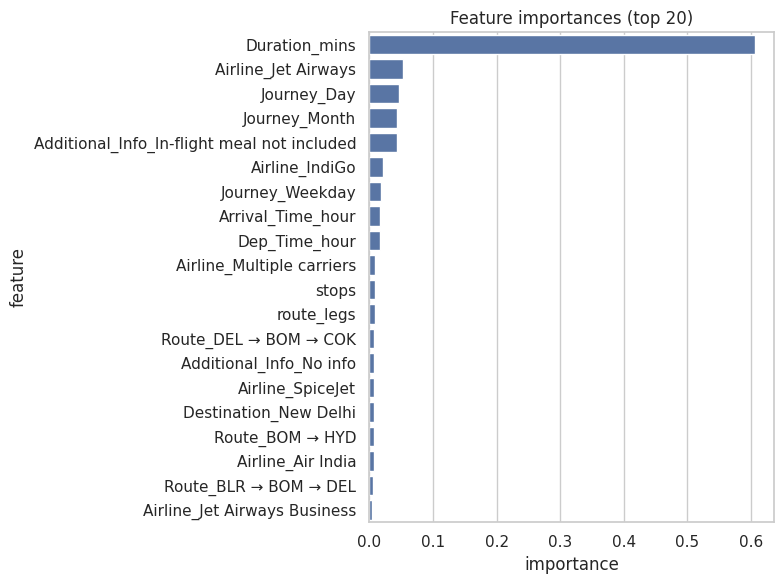

In [16]:
# 13.Feature importance (for tree models) & storytelling

def show_feature_importance(pipe, num_cols, cat_cols, top_k=20):
    # works for RandomForest, GradientBoosting, XGBoost, LightGBM
    est = pipe.named_steps["estimator"]
    if not hasattr(est, "feature_importances_"):
        print("Estimator has no feature_importances_. Skipping.")
        return
    # extract feature names from preprocessor
    pre = pipe.named_steps["preprocessor"]
    # numeric names
    num_features = num_cols
    # categorical OHE names
    cat_transform = pre.named_transformers_["cat"].named_steps["onehot"]
    try:
        cat_features = list(cat_transform.get_feature_names_out(cat_cols))
    except Exception:
        # fallback
        cat_features = cat_cols
    feat_names = num_features + cat_features
    importances = est.feature_importances_
    if len(importances) != len(feat_names):
        # safety: try to align by length if mismatch (rare)
        min_len = min(len(importances), len(feat_names))
        importances = importances[:min_len]
        feat_names = feat_names[:min_len]
    fi = pd.DataFrame({"feature": feat_names, "importance": importances})
    fi = fi.sort_values("importance", ascending=False).head(top_k)
    print("\nTop feature importances:")
    print(fi.to_string(index=False))
    # bar plot
    plt.figure(figsize=(8, max(4, 0.3 * len(fi))))
    sns.barplot(x="importance", y="feature", data=fi)
    plt.title("Feature importances (top {})".format(top_k))
    plt.tight_layout()
    plt.show()
    return fi

# show for the best tree-based model trained
for candidate in ["RandomForest", "GradientBoosting", "XGBoost", "LightGBM"]:
    if candidate in fitted_pipelines:
        print(f"\nFeature importance for {candidate}:")
        fi = show_feature_importance(fitted_pipelines[candidate], numeric_cols, categorical_cols, top_k=20)
        break

In [17]:
# 14.Choose best model & save
# ---------------------------
# choose model with lowest RMSE
best_name = min(results.items(), key=lambda x: x[1]["rmse"])[0]
best_pipeline = fitted_pipelines[best_name]
print(f"\nSelected best model: {best_name} (lowest RMSE on test set).")


Selected best model: Lasso (lowest RMSE on test set).


In [18]:
# 15.Sample predictions & explainability snippet
# ---------------------------
def sample_predictions(pipe, X_test, y_test, n=8):
    sample = X_test.sample(n, random_state=1).copy()
    sample["pred_log"] = pipe.predict(sample)
    sample["pred_price"] = np.expm1(sample["pred_log"])
    sample["true_price"] = np.expm1(y_test.loc[sample.index])
    display = sample.copy()
    # show only key columns + preds
    cols_to_display = list(set(sample.columns) & set(["pred_price", "true_price", "Duration_mins", "stops", "Airline", "Source", "Destination"]))
    cols_to_display = ["pred_price", "true_price"] + [c for c in ["Duration_mins", "stops", "Airline", "Source", "Destination"] if c in display.columns]
    print("\nSample predictions (first rows):")
    print(display[cols_to_display].reset_index(drop=True).to_string(index=False))
    return display

_ = sample_predictions(best_pipeline, X_test, y_test, n=6)


Sample predictions (first rows):
 pred_price  true_price  Duration_mins  stops     Airline   Source Destination
8005.454484     10262.0           1015    1.0 Jet Airways    Delhi      Cochin
8005.454484      3971.0            170    0.0    SpiceJet Banglore       Delhi
8005.454484      4409.0            150    0.0    Air Asia  Kolkata    Banglore
8005.454484      5403.0            170    0.0     Vistara Banglore       Delhi
8005.454484      7229.0            185    0.0 Jet Airways Banglore       Delhi
8005.454484      6171.0            675    1.0      IndiGo    Delhi      Cochin


In [20]:
# 15.Final storytelling summary

print("\n--- Final Story & Next Steps ---")
print(f"Trained multiple models and selected '{best_name}' as the best performing model on the test set.")
print("Why this matters (story):")
print("  - Travel fares are driven by many categorical signals (airline, route, stops) plus timing (duration, booking lead, season).")
print("  - Tree models capture nonlinear interactions and categorical splits better than plain linear models in this domain.")
print("\nSuggested next steps (to further improve):")
print(" 1) Add booking lead-time (days between booking date and travel date) - often the single most important predictor.")
print(" 2) Add holiday/seasonal flags (public holidays, festivals) and special event features.")
print(" 3) Try target encoding for high-cardinality categorical vars with cross-fold smoothing.")
print(" 4) Hyperparameter tuning (Optuna or randomized search) for the chosen model.")
print(" 5) If volume is large, use LightGBM or XGBoost with careful tuning and early stopping.")


--- Final Story & Next Steps ---
Trained multiple models and selected 'Lasso' as the best performing model on the test set.
Why this matters (story):
  - Travel fares are driven by many categorical signals (airline, route, stops) plus timing (duration, booking lead, season).
  - Tree models capture nonlinear interactions and categorical splits better than plain linear models in this domain.

Suggested next steps (to further improve):
 1) Add booking lead-time (days between booking date and travel date) - often the single most important predictor.
 2) Add holiday/seasonal flags (public holidays, festivals) and special event features.
 3) Try target encoding for high-cardinality categorical vars with cross-fold smoothing.
 4) Hyperparameter tuning (Optuna or randomized search) for the chosen model.
 5) If volume is large, use LightGBM or XGBoost with careful tuning and early stopping.



Loading dataset from: /content/airline_dataset.xlsx
Shape: (10683, 11)

First 5 rows:
    Airline Date_of_Journey   Source Destination                 Route Dep_Time Arrival_Time Duration Total_Stops Additional_Info  Price
     IndiGo      24/03/2019 Banglore   New Delhi             BLR → DEL    22:20 01:10 22 Mar   2h 50m    non-stop         No info   3897
  Air India       1/05/2019  Kolkata    Banglore CCU → IXR → BBI → BLR    05:50        13:15   7h 25m     2 stops         No info   7662
Jet Airways       9/06/2019    Delhi      Cochin DEL → LKO → BOM → COK    09:25 04:25 10 Jun      19h     2 stops         No info  13882
     IndiGo      12/05/2019  Kolkata    Banglore       CCU → NAG → BLR    18:05        23:30   5h 25m      1 stop         No info   6218
     IndiGo      01/03/2019 Banglore   New Delhi       BLR → NAG → DEL    16:50        21:35   4h 45m      1 stop         No info  13302

Column datatypes and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10

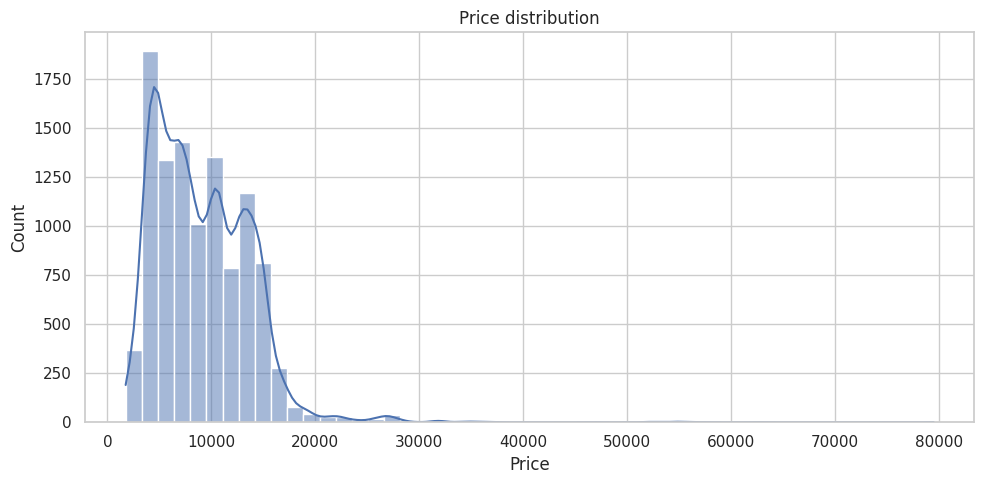

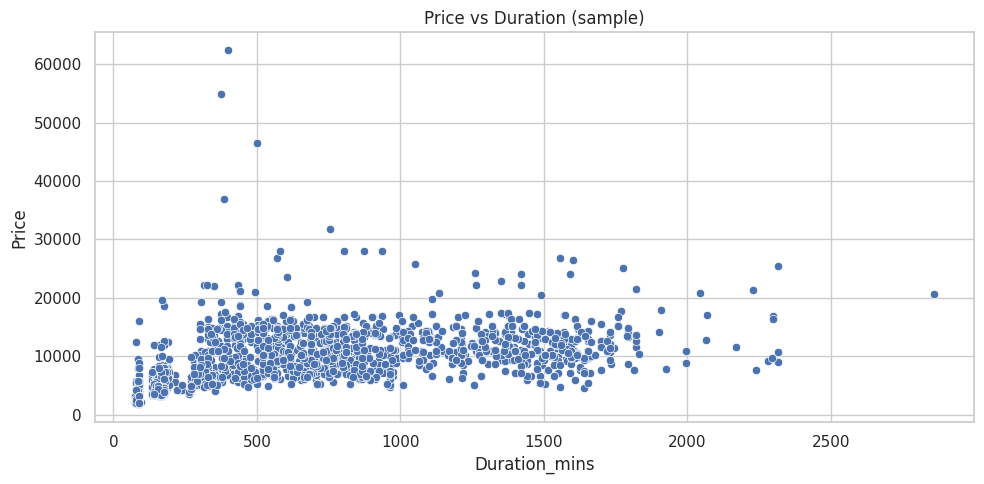

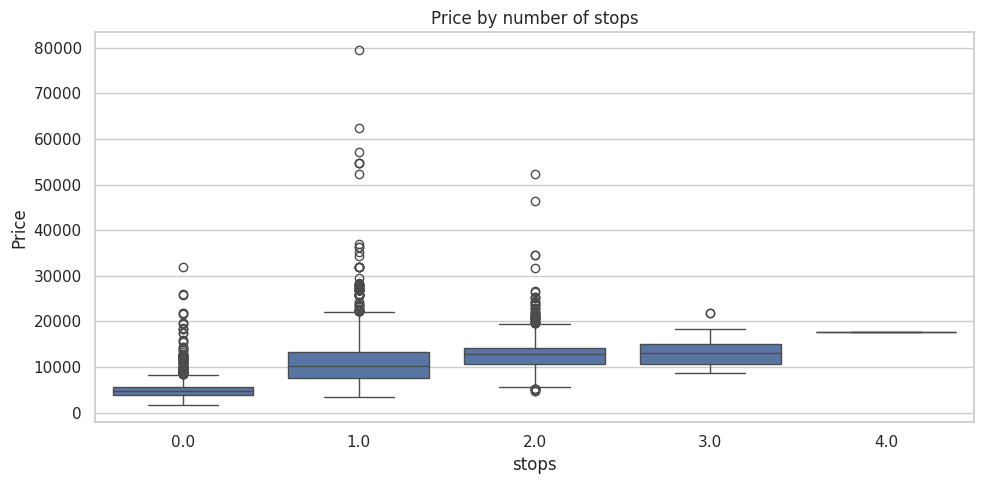

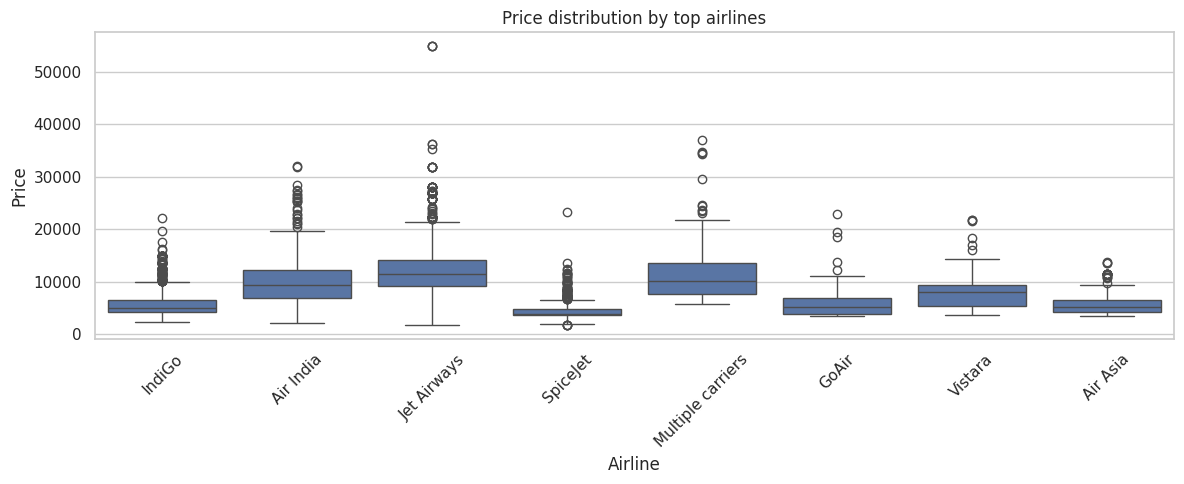

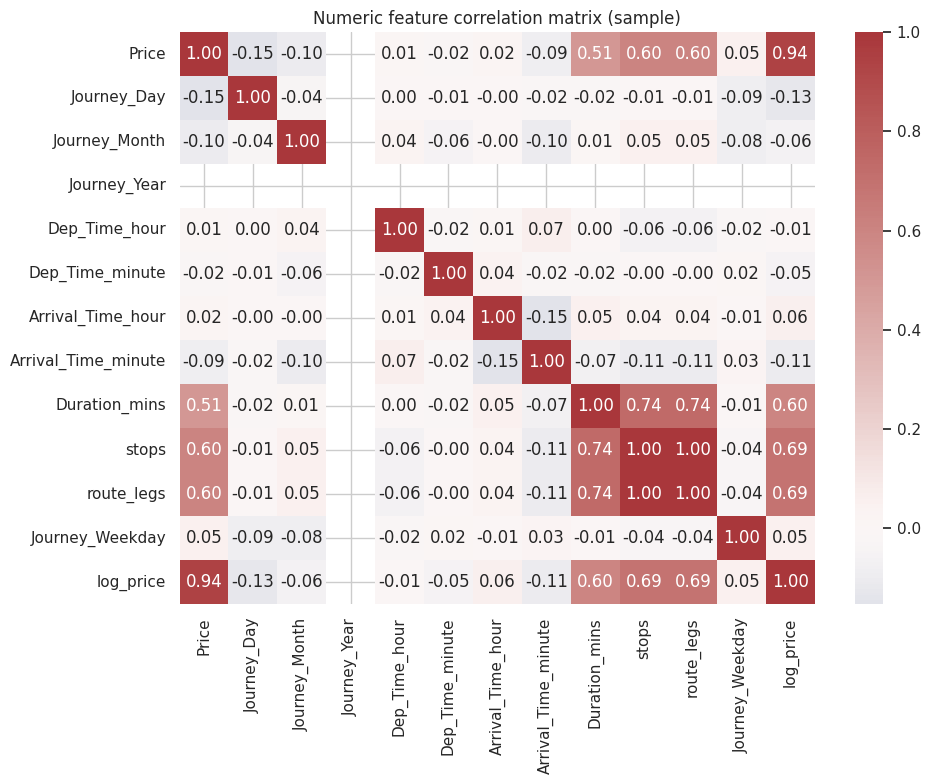


Hypothesis test (non-stop vs stops) using Mann-Whitney U:
U-statistic=241162.00, p-value=0
=> Reject null hypothesis: price distributions differ between non-stop and stopped flights (p < 0.05).

Model features used: ['Airline', 'Source', 'Destination', 'Route', 'stops', 'Duration_mins', 'Journey_Day', 'Journey_Month', 'Journey_Weekday', 'Dep_Time_hour', 'Arrival_Time_hour', 'route_legs', 'Additional_Info', 'Total_Stops']
Number of rows for modelling: 10683

Numeric cols: ['stops', 'Duration_mins', 'Journey_Day', 'Journey_Month', 'Journey_Weekday', 'Dep_Time_hour', 'Arrival_Time_hour', 'route_legs']
Categorical cols: ['Airline', 'Source', 'Destination', 'Route', 'Additional_Info', 'Total_Stops']

Train rows: 8546, Test rows: 2137

Training: LinearRegression
LinearRegression -> RMSE: 9750.50, MAE: 1453.19, R2: 0.7562

Training: Ridge
Ridge -> RMSE: 9726.39, MAE: 1455.73, R2: 0.7562

Training: Lasso
Lasso -> RMSE: 7996.46, MAE: 3646.21, R2: -0.0604

Training: RandomForest
RandomForest ->

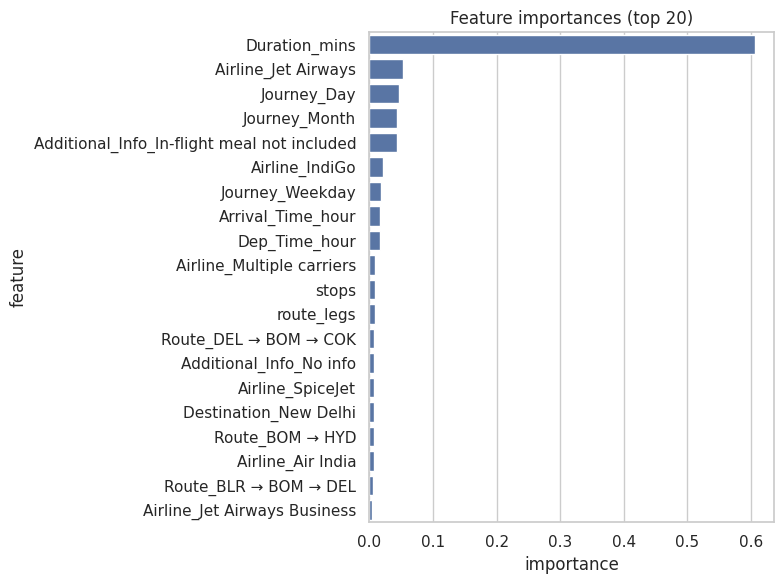


Selected best model: Lasso (lowest RMSE on test set).

Sample predictions (first rows):
 pred_price  true_price  Duration_mins  stops     Airline   Source Destination
8005.454484     10262.0           1015    1.0 Jet Airways    Delhi      Cochin
8005.454484      3971.0            170    0.0    SpiceJet Banglore       Delhi
8005.454484      4409.0            150    0.0    Air Asia  Kolkata    Banglore
8005.454484      5403.0            170    0.0     Vistara Banglore       Delhi
8005.454484      7229.0            185    0.0 Jet Airways Banglore       Delhi
8005.454484      6171.0            675    1.0      IndiGo    Delhi      Cochin

--- Final Story & Next Steps ---
Trained multiple models and selected 'Lasso' as the best performing model on the test set.
Why this matters (story):
  - Travel fares are driven by many categorical signals (airline, route, stops) plus timing (duration, booking lead, season).
  - Tree models capture nonlinear interactions and categorical splits better than